In [1]:
import scipy.io as scio
import scipy.interpolate
import pandas as pd 
import xarray as xr
import datetime as dt
import seawater as sw
import matplotlib.pyplot as plt
import sys
import src.iw_model.iw_modes  as iwm
import src.misc.iw_plots as iwp



ImportError: No module named scipy.io

/home/jpdef/anaconda3/lib/python3.7/site-packages/seawater/geostrophic.py:102: RuntimeWarning: invalid value encountered in true_divide
  n2 = -mid_g * dif_pden / (dif_z * mid_pden)
/home/jpdef/anaconda3/lib/python3.7/site-packages/seawater/geostrophic.py:104: RuntimeWarning: invalid value encountered in true_divide
  q = -cor * dif_pden / (dif_z * mid_pden)
/home/jpdef/Scripps/Projects/IW/notebooks/src/misc/iw_plots.py:28: RuntimeWarning: invalid value encountered in sqrt
  ax1.plot(3600*np.sqrt(iwm_obj.N2),iwm_obj.depth)


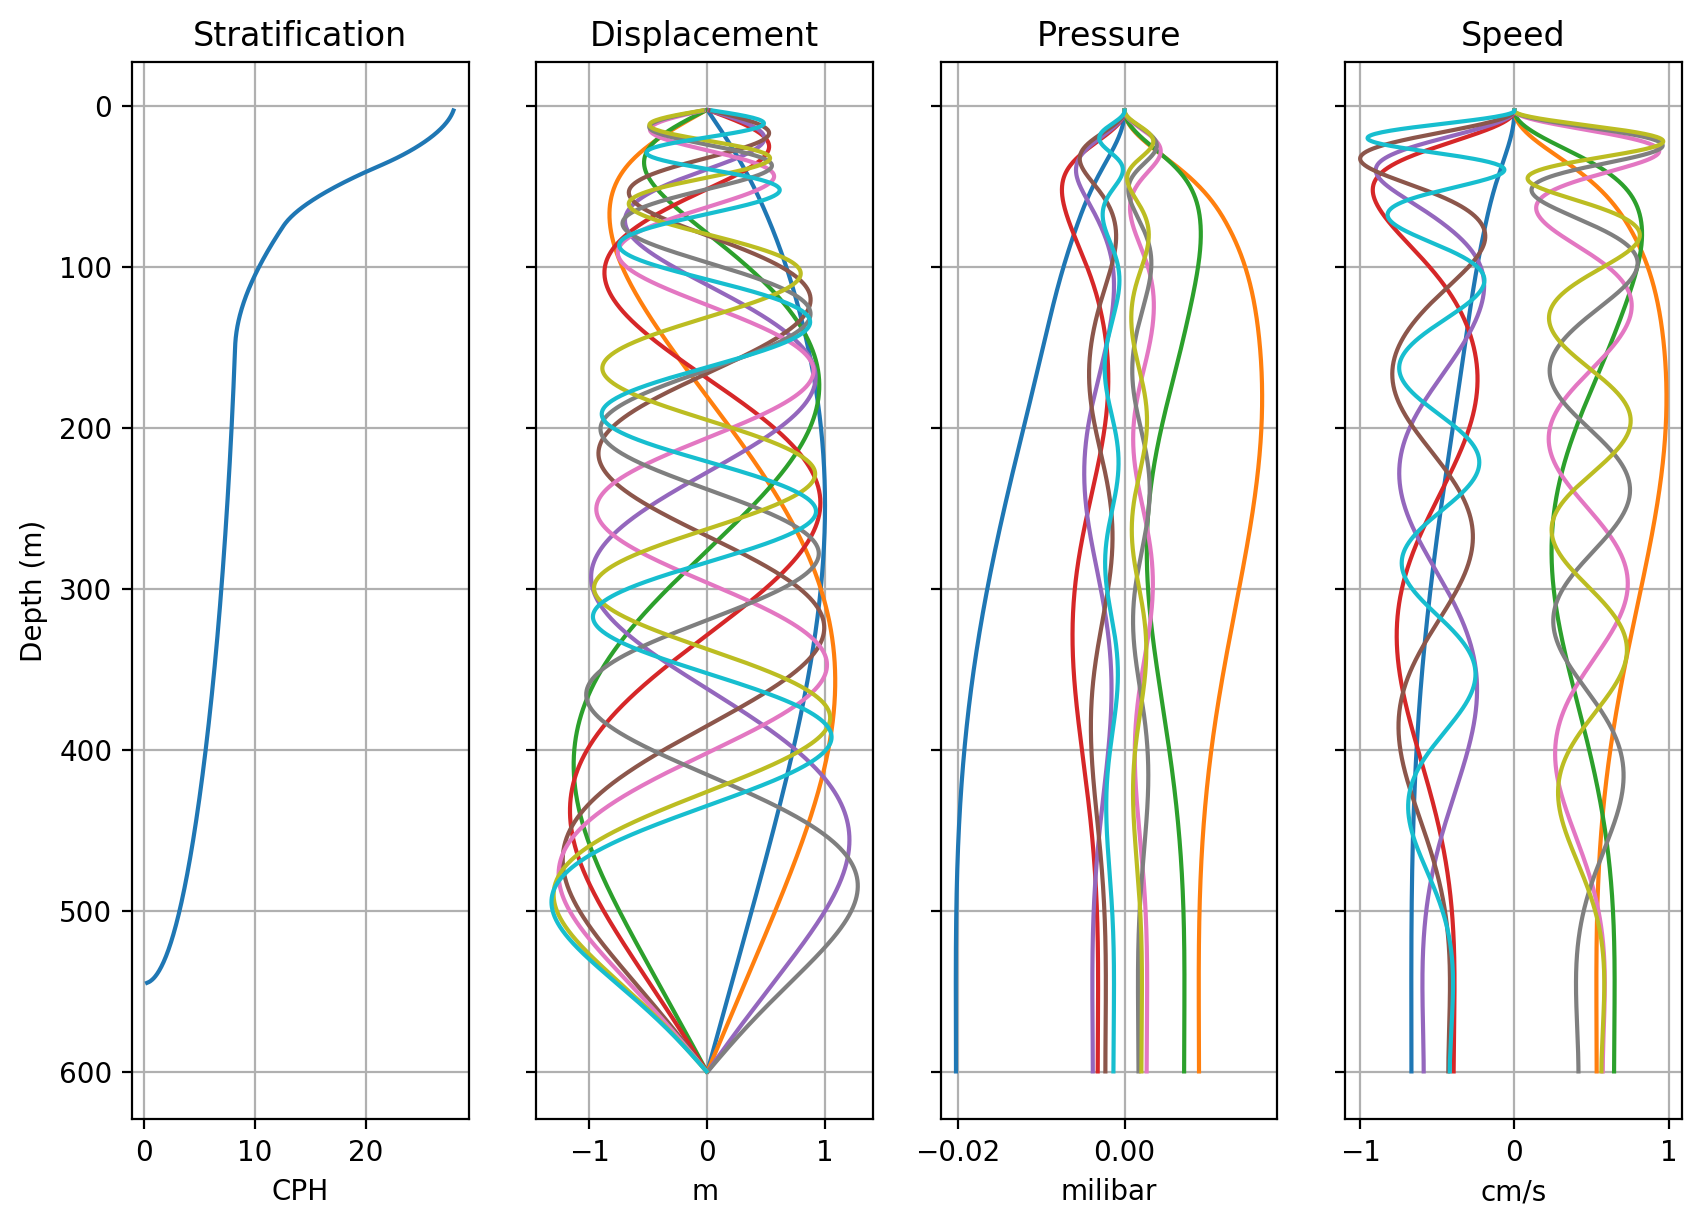

In [2]:
#Load Background Profile Data
mat  = scio.loadmat('../matlab/CTD_mean_SBC')
fT  = scipy.interpolate.UnivariateSpline(mat['depth'], mat['t_mean'], k=3, s=5)
fS  = scipy.interpolate.UnivariateSpline(mat['depth'], mat['s_mean'], k=3, s=5)
Z = mat['depth']
N2,Q,P_AVG = sw.geostrophic.bfrq( fS(Z),fT(Z),Z,lat=30)

Z = mat['depth'][:-1]
N2=N2/(2*np.pi)
Z = Z[np.logical_not(np.isnan(N2))]
N2 = N2[np.logical_not(np.isnan(N2))]

#Generate Some Modes
Omega = 1/(24*3600)
C = 2*Omega*np.sin(np.pi*30/180)
freq = 0.0805/(3600)
vm = iwm.InternalWaveModes(Z,N2,freq=freq,f=C)
f, axs = iwp.mode_plot(vm,10)
f.set_size_inches(10,7)
f.set_dpi(200)


In [4]:
vm.hwavenumbers

array([4.92018287e-05+0.j, 8.90789309e-05+0.j, 1.34935707e-04+0.j, ...,
       3.43828544e-02+0.j, 3.43451716e-02+0.j, 3.43077409e-02+0.j])

In [17]:
#T = mat['t_mean'][134:1134:20].flatten()
#S = mat['s_mean'][134:1134:20].flatten()
#df = pd.DataFrame({'depth' : Z[134:1134:20]-70 , 
#                   'strat' : N2[134:1134:20],
#                   'T'     : T,
#                   'S'     : S})
#feather.write_dataframe(df,'../config/san_clemente/env.fthr')


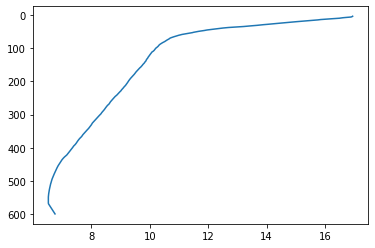

In [5]:
plt.gca().invert_yaxis()
plt.plot(mat['t_mean'],mat['depth'])

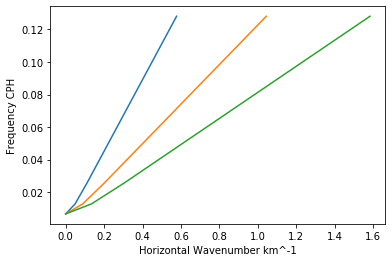

In [6]:
%load_ext autoreload
%autoreload 2
import src.iw_plots as ip
f,ax =plt.subplots()
ip.disp_plot(ax,[C,freq,2*freq,10*freq],Z,N2)

In [7]:
keys = ['time','depth','temp']

#Load TS1
mat  = scio.loadmat('../matlab/TS_1.mat')
TS1   = pd.DataFrame(dict((k, mat[k].flatten()) for k in keys))
TS1['datetime'] = pd.to_datetime(TS1['time'],unit='s')
TS1 = TS1.set_index('datetime')

#Load TS2
mat  = scio.loadmat('../matlab/TS_2.mat')
TS2   = pd.DataFrame(dict((k, mat[k].flatten()) for k in keys))
TS2['datetime'] = pd.to_datetime(TS2['time'],unit='s')
TS2 = TS2.set_index('datetime')


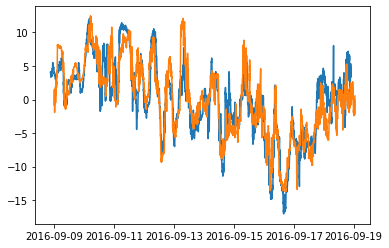

In [203]:
"""
Create a displacement field
"""

from scipy.interpolate import interp1d
import seawater as sw
import scipy

#Make interpolations of background profile to calculate displacement
mat  = scio.loadmat('../matlab/CTD_mean_SBC')
fT  = scipy.interpolate.UnivariateSpline(mat['depth'], mat['t_mean'], k=1, s=0)
fS  = scipy.interpolate.UnivariateSpline(mat['depth'], mat['s_mean'], k=1, s=0)

#Consider making this sw.eos.adtg(s,t,p)
fTz = fT.derivative()
#fTzn = sw.eos80.adtg(mat['s_mean'],mat['t_mean'],mat['depth'])
dd = np.unique(TS1['z'])
fTzn = sw.eos80.adtg(fS(dd),fT(dd),dd)


def compute_displacements(df,fT,fS,fTz):
    df['t_mean'] = fT(df['z'])
    df['s_mean'] = fS(df['z'])
    df['dt/dz']  = -fTz(df['z']) +0.001
    df['pdt/dz'] = sw.eos80.adtg(fS(df['z']),fT(df['z']),df['z'])
    df['dT'] = df['temp'] - df['t_mean']
    df['dz'] = df['dT']/df['dt/dz']
    df['pdz'] = df['dT']/(df['pdt/dz'])
    return df

TS1 = compute_displacements(TS1,fT,fS,fTz)
TS2 = compute_displacements(TS2,fT,fS,fTz)

#df['rho']    = sw.eos80.dens(df['s_mean'],df['t_mean'],df['depth'])
#bfrq,foo,bar   = sw.geostrophic.bfrq( df['s_mean'],df['t_mean'],df['depth'],lat=30)
#df['bfrq'] = np.insert(bfrq,0,0)


depths1 = np.unique(TS1['z'])
depths2 = np.unique(TS2['z'])
f , ax = plt.subplots()
ax.plot(TS1[TS1.z==depths1[5]]['dz'])
ax.plot(TS2[TS2.z==depths2[5]]['dz'])

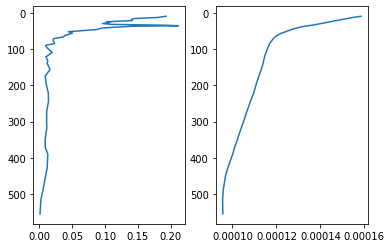

In [204]:
"""
Plot gradients of temperature computed in two ways
"""

time1 = np.unique(TS1['time'])
time2 = np.unique(TS2['time'])
f , ax = plt.subplots(1,2)
a = TS1[TS1.time==time1[10]]
ax[0].plot(a['dt/dz'].values,a['z'],)
ax[1].plot(a['pdt/dz'].values,a['z'],)
ax[0].invert_yaxis()
ax[1].invert_yaxis()

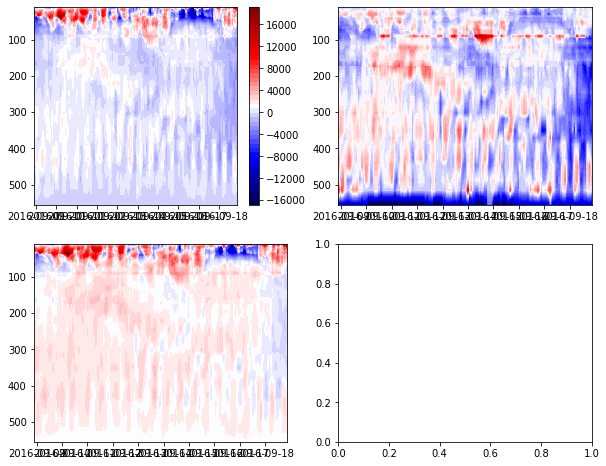

In [205]:
"""
Plot displacement
"""

f, ax = plt.subplots(2,2)

TSR = TS1.resample('1H').first()
TSR = TS1.loc[ TS1['time'].isin(TSR.time)]

zz,tt = np.meshgrid( np.unique(TSR.z), np.unique(TSR.index) )
pdz = np.array(TSR['pdz']).reshape(zz.shape)
dz = np.array(TSR['dz']).reshape(zz.shape)
p=ax[0,0].contourf(tt,zz,pdz,levels=50,cmap='seismic')
ax[0,1].contourf(tt,zz,dz,levels=50,cmap='seismic')
ax[0,0].invert_yaxis()
ax[0,1].invert_yaxis()
f.colorbar(p,ax=ax[0,0])

"""
Plot Temperature Anomaly
"""

TSR = TS1.resample('1H').first()
TSR = TS1.loc[ TS1['time'].isin(TSR.time)]

zz,tt = np.meshgrid( np.unique(TSR.z), np.unique(TSR.index) )
temp = np.array(TSR.dT).reshape(zz.shape)
ax[1,0].invert_yaxis()
ax[1,0].contourf(tt,zz,temp,levels=50,cmap='seismic')


f.set_size_inches(10,8)

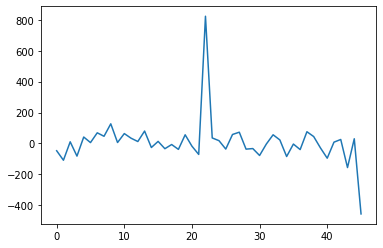

In [202]:
plt.plot(np.mean(pdz,axis=0))


In [207]:
#Correct location
import utils
c =  [(34.2545,-120.0974), (34.2389,-120.1026)]
dx = utils.distance( (34.2389,-120.0974), (34.2389,-120.1026) )
dy = utils.distance( (34.2545,-120.1026), (34.2389,-120.1026) )

TS1['x'] = np.ones(len(TS1))*dx
TS1['y'] = np.ones(len(TS1))*dy
TS1 = TS1.rename(columns={'depth':'z'})

TS2['x'] = np.zeros(len(TS2))
TS2['y'] = np.zeros(len(TS2))
TS2 = TS2.rename(columns={'depth':'z'})

TS = pd.concat([TS1,TS2])
TS

,time,z,temp,t_mean,s_mean,dt/dz,dT,dz,x,y,pdt/dz,pdz
datetime,,,,,,,,,,,,
2016-09-08 21:10:00,1473369000,9.420437,16.010,16.406338,33.456223,0.192827,-0.396338,-2.055405,0.478008,1.734641,0.000158,-2500.945676
2016-09-08 21:10:00,1473369000,10.910527,15.724,16.175773,33.446319,0.186982,-0.451773,-2.416131,0.478008,1.734641,0.000157,-2879.555968
2016-09-08 21:10:00,1473369000,12.985729,15.509,15.847993,33.443756,0.178710,-0.338993,-1.896887,0.478008,1.734641,0.000155,-2192.099925
2016-09-08 21:10:00,1473369000,15.922649,15.485,15.484707,33.439435,0.143041,0.000293,0.002045,0.478008,1.734641,0.000152,1.922825
2016-09-08 21:10:00,1473369000,18.679154,15.438,15.099839,33.443298,0.139911,0.338161,2.416973,0.478008,1.734641,0.000150,2261.886884
...,...,...,...,...,...,...,...,...,...,...,...,...
2016-09-19 00:59:00,1474246740,420.383950,6.889,7.172784,34.236250,0.007939,-0.283784,-35.744704,0.000000,0.000000,0.000098,-2881.997275
2016-09-19 00:59:00,1474246740,446.164865,6.763,6.924344,34.244429,0.010336,-0.161344,-15.609596,0.000000,0.000000,0.000097,-1663.446483
2016-09-19 00:59:00,1474246740,487.613558,6.585,6.686557,34.253888,0.006457,-0.101557,-15.727836,0.000000,0.000000,0.000096,-1059.807024


In [208]:
#Write out data
write_it = True

import feather
if write_it == True:
    strat_df = pd.DataFrame({'strat': N2, 'depth': Z})
    feather.write_dataframe(strat_df,'sbc_strat.fthr')
    feather.write_dataframe(TS,'sbc2.fthr')